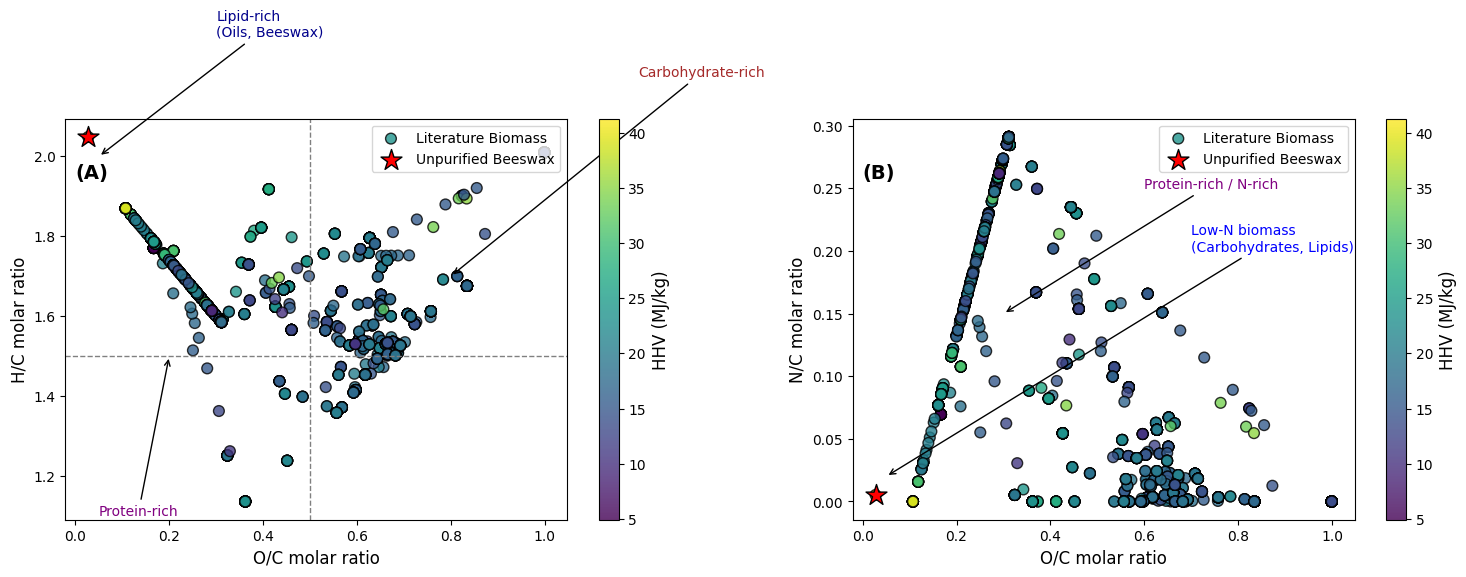

Index(['Author', 'Ref', 'Resource', 'Details', 'Origin', 'Method',
       'HHVResource', 'CarboHydrates', 'Lignin', 'Cellulose', 'HemiCellulose',
       'Sugar', 'Proteins', 'Lipids', 'Ash', 'Guaiacol', 'FattyAcids',
       'Glycerol', 'CarboxylicAcids', 'AminoAcids', 'Additive', 'AddQtty(g/L)',
       'DryMatter', 'HeatingRate', 'HeatingProfile', 'HeatingTime',
       'HoldingTime', 'TotalTime', 'Temperature', 'Solvent', 'Polarity',
       'Biocrude', 'Oil', 'Char', 'Gas', 'WaterPhase', 'C_approx', 'H_approx',
       'O_approx', 'N_approx', 'approx_coverage_frac', 'low_coverage_flag'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Author                2439 non-null   object 
 1   Ref                   2440 non-null   object 
 2   Resource              2439 non-null   object 
 3   Details          

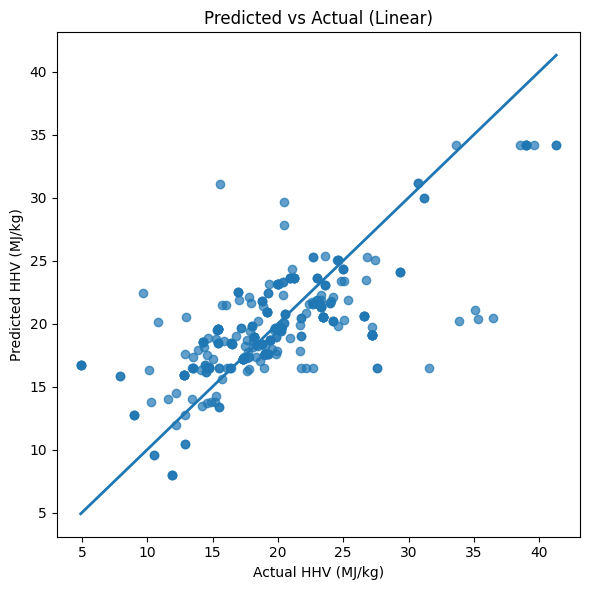

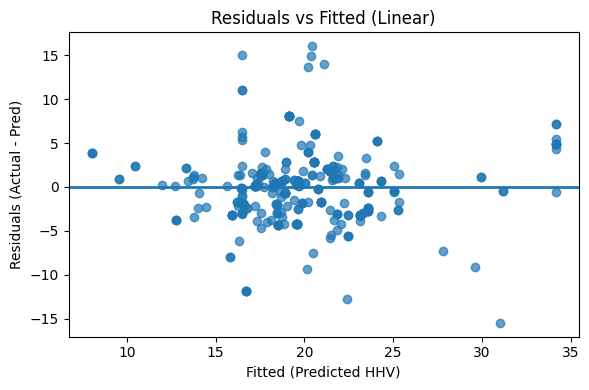

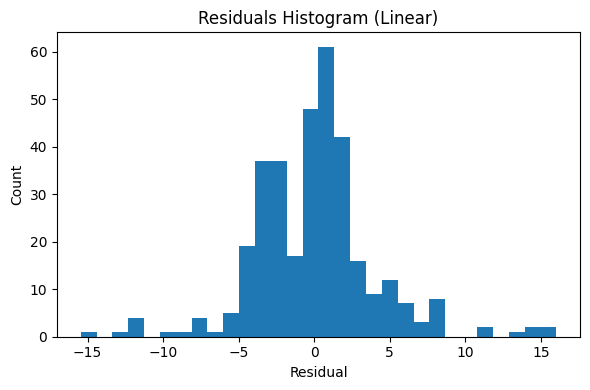

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     207.6
Date:                Mon, 20 Oct 2025   Prob (F-statistic):          3.78e-209
Time:                        07:56:26   Log-Likelihood:                -3787.6
No. Observations:                1360   AIC:                             7591.
Df Residuals:                    1352   BIC:                             7633.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6597      0.107    184.416      0.0

C:\Users\check\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '
C:\Users\check\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


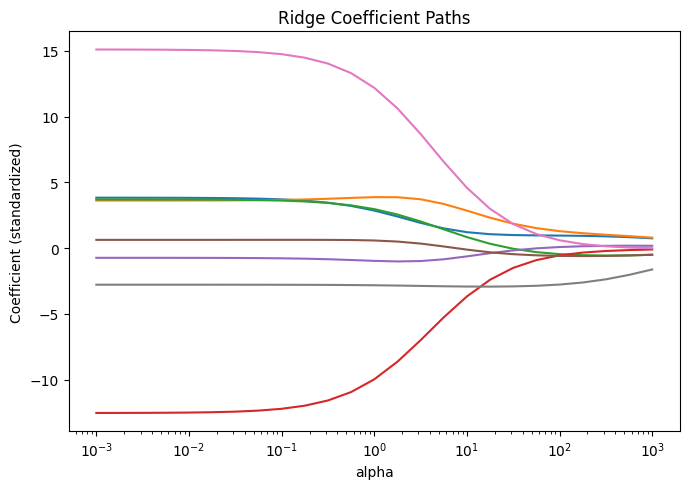


[Ridge] Intercept (original scale): -28.926784
[Ridge] Coefficients (original scale):
    feature  coef_ridge
6       N_C  146.056349
4       H_C   -4.661970
1  H_approx    2.683609
5       O_C    2.584306
3  N_approx   -1.882534
0  C_approx    0.468822
2  O_approx    0.290319
7       Ash   -0.236912

=== Coefficient variance (bootstrap, standardized scale) ===
    feature  Var_OLS(std_scale)  Var_Ridge(std_scale)  Ridge/OLS_Var_Ratio
3  N_approx            2.039797              1.975495             0.968476
6       N_C            2.931675              2.851116             0.972521
0  C_approx            0.893106              0.869008             0.973018
4       H_C            0.430987              0.420247             0.975080
1  H_approx            1.403824              1.371811             0.977196
2  O_approx            0.260755              0.255419             0.979536
5       O_C            1.082826              1.069646             0.987829
7       Ash            0.025069    

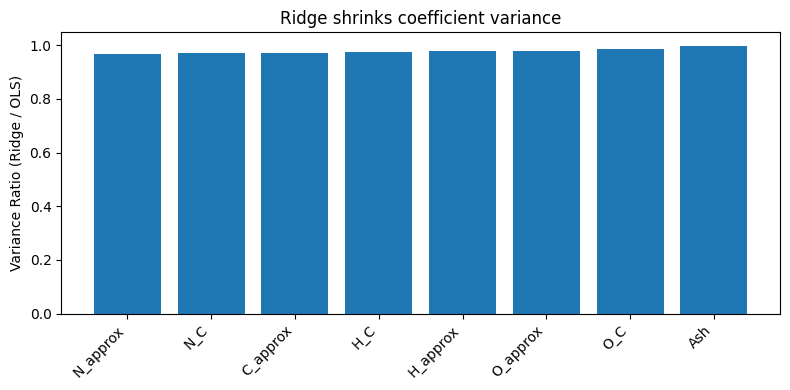

Saved models/predictions and plots.


In [3]:
# ------------------------------
# Step 1. Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib


# ------------------------------
# Step 2. Load and Clean Data
# ------------------------------
file_path = "dataset.xlsx"   # <-- change path if needed
df = pd.read_excel(file_path, sheet_name="Data")



# Replace -1 with NaN only in numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace(-1, np.nan)

# ------------------------------
# Step 3. Approximate Ultimate Analysis
# ------------------------------
# Reference biochemical elemental composition (wt%)
ref = {
    "Cellulose": {"C":44.4,"H":6.2,"O":49.4,"N":0},
    "HemiCellulose": {"C":44.4,"H":6.2,"O":49.4,"N":0},
    "Sugar": {"C":40.0,"H":6.7,"O":53.3,"N":0},
    "Lignin": {"C":63.4,"H":6.0,"O":30.6,"N":0},
    "Proteins": {"C":53.0,"H":7.0,"O":22.0,"N":18.0},
    "Lipids": {"C":77.0,"H":12.0,"O":11.0,"N":0},
}

# Initialize new columns
for elem in ["C","H","O","N"]:
    df[f"{elem}_approx"] = 0.0

# Accumulate contributions row by row
for comp, formula in ref.items():
    if comp in df.columns:
        frac = (df[comp].astype(float).fillna(0.0))/100.0
        for elem in ["C","H","O","N"]:
            df[f"{elem}_approx"] += frac * formula[elem]

# Coverage check (how much biomass is described by biochemical fractions)
df["approx_coverage_frac"] = df[[c for c in ref.keys() if c in df.columns]].fillna(0).sum(axis=1)/100

# Normalize so C+H+O+N = 100 (only where row sum > 0)
row_sums = df[["C_approx","H_approx","O_approx","N_approx"]].sum(axis=1)
mask = row_sums > 0
df.loc[mask, ["C_approx","H_approx","O_approx","N_approx"]] = (
    df.loc[mask, ["C_approx","H_approx","O_approx","N_approx"]]
      .div(row_sums[mask], axis=0)*100
)

# Flag low coverage rows (<60%)
df["low_coverage_flag"] = df["approx_coverage_frac"] < 0.6

# ------------------------------
# Step 4. Add Beeswax Row
# ------------------------------
beeswax = {
    "Author": "Literature",
    "Ref": "Beeswax_lit",
    "Resource": "Beeswax",
    "Details": "Unpurified Beeswax (literature)",
    "C_approx": 82.0,
    "H_approx": 14.0,
    "O_approx": 3.0,
    "N_approx": 0.5,
    "HHVResource": 38.0   # placeholder, update if you have experimental HHV
}

beeswax_df = pd.DataFrame([beeswax])

# Calculate ratios for beeswax
beeswax_df["H_C"] = (beeswax_df["H_approx"]/1.0) / (beeswax_df["C_approx"]/12.0)
beeswax_df["O_C"] = (beeswax_df["O_approx"]/16.0) / (beeswax_df["C_approx"]/12.0)
beeswax_df["N_C"] = (beeswax_df["N_approx"]/14.0) / (beeswax_df["C_approx"]/12.0)

# Append beeswax row to dataset
df_all = pd.concat([df, beeswax_df], ignore_index=True)

# ------------------------------
# Step 5. Calculate Ratios (for all rows)
# ------------------------------
df_all["H_C"] = np.where(df_all["C_approx"]>0, (df_all["H_approx"]/1.0)/(df_all["C_approx"]/12.0), np.nan)
df_all["O_C"] = np.where(df_all["C_approx"]>0, (df_all["O_approx"]/16.0)/(df_all["C_approx"]/12.0), np.nan)
df_all["N_C"] = np.where(df_all["C_approx"]>0, (df_all["N_approx"]/14.0)/(df_all["C_approx"]/12.0), np.nan)

# ------------------------------
# Step 6. Plot Van Krevelen Panels (with Cluster Annotations)
# ------------------------------
vk = df_all.dropna(subset=["H_C","O_C","N_C"])
bw_mask = vk["Resource"].str.contains("Beeswax", case=False, na=False)

fig, axes = plt.subplots(1, 2, figsize=(15,6))

# --- Panel A: H/C vs O/C ---
sc1 = axes[0].scatter(vk["O_C"], vk["H_C"],
                      c=vk["HHVResource"], cmap="viridis",
                      s=60, edgecolor="k", alpha=0.8,
                      label="Literature Biomass")

axes[0].scatter(vk.loc[bw_mask,"O_C"], vk.loc[bw_mask,"H_C"],
                c="red", marker="*", s=250, edgecolor="k",
                label="Unpurified Beeswax")

# Subfigure label
axes[0].text(0.02,0.85,"(A)", transform=axes[0].transAxes,
             fontsize=14, fontweight="bold")

# Axis labels
axes[0].set_xlabel("O/C molar ratio", fontsize=12)
axes[0].set_ylabel("H/C molar ratio", fontsize=12)

# Reference lines
axes[0].axhline(y=1.5, color="gray", linestyle="--", lw=1)
axes[0].axvline(x=0.5, color="gray", linestyle="--", lw=1)

# Cluster annotations with arrows
axes[0].annotate("Carbohydrate-rich", xy=(0.8,1.7), xytext=(1.2,2.2),
                 arrowprops=dict(facecolor="brown", arrowstyle="->"),
                 fontsize=10, color="brown")

axes[0].annotate("Lignin-rich", xy=(0.3,1.0), xytext=(0.6,0.6),
                 arrowprops=dict(facecolor="darkgreen", arrowstyle="->"),
                 fontsize=10, color="darkgreen")

axes[0].annotate("Lipid-rich\n(Oils, Beeswax)", xy=(0.05,2.0), xytext=(0.3,2.3),
                 arrowprops=dict(facecolor="darkblue", arrowstyle="->"),
                 fontsize=10, color="darkblue")

axes[0].annotate("Protein-rich", xy=(0.2,1.5), xytext=(0.05,1.1),
                 arrowprops=dict(facecolor="purple", arrowstyle="->"),
                 fontsize=10, color="purple")

# Colorbar
cbar = fig.colorbar(sc1, ax=axes[0])
cbar.set_label("HHV (MJ/kg)", fontsize=12)

# Legend
axes[0].legend(frameon=True, fontsize=10, loc="upper right")


# --- Panel B: N/C vs O/C ---
sc2 = axes[1].scatter(vk["O_C"], vk["N_C"],
                      c=vk["HHVResource"], cmap="viridis",
                      s=60, edgecolor="k", alpha=0.8,
                      label="Literature Biomass")

axes[1].scatter(vk.loc[bw_mask,"O_C"], vk.loc[bw_mask,"N_C"],
                c="red", marker="*", s=250, edgecolor="k",
                label="Unpurified Beeswax")

# Subfigure label
axes[1].text(0.02,0.85,"(B)", transform=axes[1].transAxes,
             fontsize=14, fontweight="bold")

# Axis labels
axes[1].set_xlabel("O/C molar ratio", fontsize=12)
axes[1].set_ylabel("N/C molar ratio", fontsize=12)

# Cluster annotations for N/C space
axes[1].annotate("Protein-rich / N-rich", xy=(0.3,0.15), xytext=(0.6,0.25),
                 arrowprops=dict(facecolor="purple", arrowstyle="->"),
                 fontsize=10, color="purple")

axes[1].annotate("Low-N biomass\n(Carbohydrates, Lipids)", xy=(0.05,0.02), xytext=(0.7,0.2),
                 arrowprops=dict(facecolor="blue", arrowstyle="->"),
                 fontsize=10, color="blue")

# Colorbar
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label("HHV (MJ/kg)", fontsize=12)

# Legend
axes[1].legend(frameon=True, fontsize=10, loc="upper right")


# ------------------------------
# Save high-resolution versions
# ------------------------------
plt.tight_layout()
plt.savefig("van_krevelen_with_clusters.png", dpi=300, bbox_inches="tight")
plt.savefig("van_krevelen_with_clusters.tiff", dpi=300, bbox_inches="tight")
plt.savefig("van_krevelen_with_clusters.pdf", bbox_inches="tight")
plt.show()


#show first 5 row
#df.head()

# see all column name
print(df.columns)

# Check general info
df.info()

# Get summary statistics for numeric columns
df.describe()



# ==============================
# Step 7. Modeling Setup
# ==============================
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import joblib

def rmse_score(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

TARGET = "HHVResource"

# Prefer approximated elemental + ratios + common proximate if present
preferred_features = [
    "C_approx","H_approx","O_approx","N_approx",
    "H_C","O_C","N_C",
    "VM","FixedCarbon","FC","Ash","Moisture"
]
feature_cols = [c for c in preferred_features if c in df_all.columns]
if not feature_cols:
    # Fallback: all numeric except target
    feature_cols = [c for c in df_all.select_dtypes(include=[np.number]).columns if c != TARGET]

print("Using features:", feature_cols)

# Optional: drop synthetic beeswax if HHV is a placeholder
work = df_all.copy()
work = work[feature_cols + [TARGET]].copy()

# Ensure numeric + drop NaNs
for c in feature_cols + [TARGET]:
    work[c] = pd.to_numeric(work[c], errors="coerce")
work = work.dropna(subset=feature_cols + [TARGET])

X = work[feature_cols].to_numpy()
y = work[TARGET].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# A single scaler reused below
scaler = StandardScaler(with_mean=True, with_std=True)

# ==============================
# Step 8. Linear Regression + CV
# ==============================
lin_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lin", LinearRegression())
])
lin_pipe.fit(X_train, y_train)

y_pred = lin_pipe.predict(X_test)
print(f"[Linear] Test R^2  : {r2_score(y_test, y_pred):.4f}")
print(f"[Linear] Test MAE  : {mean_absolute_error(y_test, y_pred):.4f} MJ/kg")
print(f"[Linear] Test RMSE : {rmse_score(y_test, y_pred):.4f} MJ/kg")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(lin_pipe, X, y, cv=cv, scoring="r2")
print(f"[Linear] 5-fold R^2: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

# ==============================
# Step 9. Diagnostic Plots
# ==============================
# (1) Pred vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
ymin, ymax = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([ymin, ymax], [ymin, ymax], linewidth=2)
plt.xlabel("Actual HHV (MJ/kg)")
plt.ylabel("Predicted HHV (MJ/kg)")
plt.title("Predicted vs Actual (Linear)")
plt.tight_layout()
plt.savefig("lin_pred_vs_actual.png", dpi=300)
plt.show()

# (2) Residuals vs Fitted
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, linewidth=2)
plt.xlabel("Fitted (Predicted HHV)")
plt.ylabel("Residuals (Actual - Pred)")
plt.title("Residuals vs Fitted (Linear)")
plt.tight_layout()
plt.savefig("lin_residuals_vs_fitted.png", dpi=300)
plt.show()

# (3) Residuals histogram
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram (Linear)")
plt.tight_layout()
plt.savefig("lin_residuals_hist.png", dpi=300)
plt.show()

# ==============================
# Step 10. OLS (statsmodels) + robust SEs
# ==============================
Xtr_std = scaler.fit_transform(X_train)
Xtr_std_sm = sm.add_constant(Xtr_std)
ols_model = sm.OLS(y_train, Xtr_std_sm).fit()
print(ols_model.summary())

ols_model_hc3 = ols_model.get_robustcov_results(cov_type="HC3")
print("\n=== OLS with HC3 robust SEs ===")
print(ols_model_hc3.summary())

# ==============================
# Step 11. RidgeCV + Coef Paths
# ==============================
alphas = np.logspace(-3, 3, 25)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

Xte_std = scaler.transform(X_test)
ridge_cv.fit(Xtr_std, y_train)
y_pred_ridge = ridge_cv.predict(Xte_std)

print(f"[Ridge] Best alpha (CV): {ridge_cv.alpha_:.4f}")
print(f"[Ridge] Test R^2  : {r2_score(y_test, y_pred_ridge):.4f}")
print(f"[Ridge] Test MAE  : {mean_absolute_error(y_test, y_pred_ridge):.4f} MJ/kg")
print(f"[Ridge] Test RMSE : {rmse_score(y_test, y_pred_ridge):.4f} MJ/kg")

# Coefficient paths on standardized scale
coefs = []
for a in alphas:
    m = Ridge(alpha=a).fit(Xtr_std, y_train)
    coefs.append(m.coef_)
coefs = np.array(coefs)

plt.figure(figsize=(7,5))
for j in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, j])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Coefficient (standardized)")
plt.title("Ridge Coefficient Paths")
plt.tight_layout()
plt.savefig("ridge_coef_paths.png", dpi=300)
plt.show()

# Coefficients back to original data scale
coef_orig = ridge_cv.coef_ / scaler.scale_
intercept_orig = ridge_cv.intercept_ - np.sum(coef_orig * scaler.mean_)
coef_table_ridge = pd.DataFrame({"feature": feature_cols, "coef_ridge": coef_orig}).sort_values(
    by="coef_ridge", key=lambda s: s.abs(), ascending=False
)
print("\n[Ridge] Intercept (original scale):", round(intercept_orig, 6))
print("[Ridge] Coefficients (original scale):")
print(coef_table_ridge)

# ==============================
# Step 12. Variance: OLS vs Ridge (bootstrap)
# ==============================
B = 300
rng = np.random.default_rng(42)
n, p = Xtr_std.shape
ols_coefs = np.zeros((B, p))
ridge_coefs = np.zeros((B, p))

best_alpha = ridge_cv.alpha_
for b in range(B):
    idx = rng.integers(0, n, size=n)
    Xb = Xtr_std[idx]
    yb = y_train[idx]

    ols_b = LinearRegression().fit(Xb, yb)
    ols_coefs[b, :] = ols_b.coef_

    ridge_b = Ridge(alpha=best_alpha).fit(Xb, yb)
    ridge_coefs[b, :] = ridge_b.coef_

ols_var   = ols_coefs.var(axis=0, ddof=1)
ridge_var = ridge_coefs.var(axis=0, ddof=1)

var_table = pd.DataFrame({
    "feature": feature_cols,
    "Var_OLS(std_scale)": ols_var,
    "Var_Ridge(std_scale)": ridge_var,
    "Ridge/OLS_Var_Ratio": ridge_var / (ols_var + 1e-12)
}).sort_values(by="Ridge/OLS_Var_Ratio")

print("\n=== Coefficient variance (bootstrap, standardized scale) ===")
print(var_table)

plt.figure(figsize=(8,4))
plt.bar(var_table["feature"], var_table["Ridge/OLS_Var_Ratio"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variance Ratio (Ridge / OLS)")
plt.title("Ridge shrinks coefficient variance")
plt.tight_layout()
plt.savefig("ridge_vs_ols_variance_ratio.png", dpi=300)
plt.show()

# ==============================
# Step 13. Save artifacts
# ==============================
# Save linear model pipeline and predictions
joblib.dump(lin_pipe, "hhv_linear_model.joblib")
pd.DataFrame({"y_test_actual": y_test, "y_test_pred_linear": y_pred}).to_csv(
    "hhv_linear_test_predictions.csv", index=False
)
# Save ridge predictions too
pd.DataFrame({"y_test_actual": y_test, "y_test_pred_ridge": y_pred_ridge}).to_csv(
    "hhv_ridge_test_predictions.csv", index=False
)
print("Saved models/predictions and plots.")
